In [1]:
# Load packages

import pandas as pd
import altair as alt
from vega_datasets import data 
import numpy

# Need to enable this to allow work with larger datasets (https://altair-viz.github.io/user_guide/faq.html)
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [2]:
#reassigning for easier debugging
df = data.jobs()
# remove `perc` column
df = df.drop(columns = 'perc')

grouped_jobs = df.pivot_table(
  columns=['sex'], 
  values=['count'], 
  index=['year', 'job']
)

# Categorize each row into a gender dominant group 
# based on its male to female ratio of that year
def categorize_gender_dominant_group(row):  
    male_count = row['count']['men']
    female_count = row['count']['women']
    if male_count == 0 and female_count == 0:
        return 'no job'
    elif row['count']['women'] == 0:
        return 'only male'
    elif row['count']['men'] == 0:
        return 'only female'
    elif (male_count/female_count) >= 2:
        return 'male dominant'
    elif (male_count/female_count) <= 0.5:
        return 'female dominant'
    else:
        return 'balanced'

# Compute the difference in proportion of men and women by job by year
def compute_gender_prop_diff(row):  
    male_count = row['count']['men']
    female_count = row['count']['women']
    
    if male_count+female_count == 0:
        return float('NaN')
    else:
        return (male_count-female_count)/(male_count+female_count)

grouped_jobs.head()

count      
sex                         men women
year job                             
1850 Accountant / Auditor   708     0
     Actor                  506     0
     Advertising Agent        0     0
     Agent                 2528     0
     Apprentice            3134   101

In [3]:
# Compute the difference in proportion of men and women by job by year
def compute_total_gender_ratio(row):  
    male_total = row['count']['men']
    female_total = row['count']['women']
    return male_total/female_total

ratios_df = pd.DataFrame({'ratio':grouped_jobs.groupby(['job']).sum().apply(compute_total_gender_ratio, axis=1)}).reset_index()


In [4]:
grouped_jobs['gender_dominant_group'] = grouped_jobs.apply(categorize_gender_dominant_group, axis=1)
grouped_jobs['gender_prop_diff'] = grouped_jobs.apply(compute_gender_prop_diff, axis=1)

grouped_jobs.head()


count       gender_dominant_group gender_prop_diff
sex                         men women                                       
year job                                                                    
1850 Accountant / Auditor   708     0             only male         1.000000
     Actor                  506     0             only male         1.000000
     Advertising Agent        0     0                no job              NaN
     Agent                 2528     0             only male         1.000000
     Apprentice            3134   101         male dominant         0.937558

In [5]:
jobs_tidy = grouped_jobs.drop(['count'], axis=1)
jobs_tidy = jobs_tidy.reset_index()
jobs_tidy.columns=jobs_tidy.columns.droplevel(1)
# remove any rows with no observations (the next chunk will then remove these jobs completely)
jobs_tidy = jobs_tidy.query("gender_dominant_group != 'no job'")
# remove jobs that do not have data for both genders for all 15 years
full_year_data = jobs_tidy.groupby(["job"]).count().query("year == 15").reset_index()[["job"]]
jobs_tidy = jobs_tidy[jobs_tidy["job"].isin(full_year_data["job"])]
ratios_df = ratios_df[ratios_df["job"].isin(full_year_data["job"])]
ratios_df.to_csv('job_ratios.csv')
jobs_tidy
jobs_tidy.to_csv('jobs_tidy.csv')

In [6]:
jobs_tidy_complete = jobs_tidy.merge(ratios_df, how = "inner", on = ["job"]).merge(df, how = "inner", on = ["year","job"])
jobs_tidy_complete.head()


,year,job,gender_dominant_group,gender_prop_diff,ratio,sex,count
0,1850,Architect,only male,1.0,7.032999,men,405
1,1850,Architect,only male,1.0,7.032999,women,0
2,1860,Architect,only male,1.0,7.032999,men,1707
3,1860,Architect,only male,1.0,7.032999,women,0
4,1870,Architect,only male,1.0,7.032999,men,1914


In [7]:
# Count the group
gender_dominant_group_count_df = (
    jobs_tidy.groupby(['job', 'gender_dominant_group']).size().unstack(fill_value = 0)
)
# Reset the index
gender_dominant_group_count_df = gender_dominant_group_count_df.reset_index()
gender_dominant_group_count_df.columns.name = ''
# Set the total column


gender_dominant_group_count_df = gender_dominant_group_count_df[['job','only male','male dominant','balanced', 'female dominant', 'only female']]

gender_dominant_group_count_df.head()



,job,only male,male dominant,balanced,female dominant,only female
0,Architect,6,9,0,0,0
1,Artist / Art Teacher,1,3,11,0,0
2,Author,1,2,12,0,0
3,Baker,0,11,4,0,0
4,Barber / Beautician,0,8,3,4,0


In [8]:
gender_dominant_group_count_df['only male'] = gender_dominant_group_count_df['only male']*2
gender_dominant_group_count_df['male dominant'] = gender_dominant_group_count_df['male dominant']*1
gender_dominant_group_count_df['balanced'] = gender_dominant_group_count_df['balanced']*0
gender_dominant_group_count_df['female dominant'] = gender_dominant_group_count_df['female dominant']*(-1)
gender_dominant_group_count_df['only female'] = gender_dominant_group_count_df['only female']*(-2)

gender_dominant_group_count_df.head()

,job,only male,male dominant,balanced,female dominant,only female
0,Architect,12,9,0,0,0
1,Artist / Art Teacher,2,3,0,0,0
2,Author,2,2,0,0,0
3,Baker,0,11,0,0,0
4,Barber / Beautician,0,8,0,-4,0


In [9]:
gender_dominant_group_count_df['total'] = gender_dominant_group_count_df.loc[
  :, gender_dominant_group_count_df.columns != 'job'
].apply(sum, axis = 1)

gender_dominant_group_count_df.head()



,job,only male,male dominant,balanced,female dominant,only female,total
0,Architect,12,9,0,0,0,21
1,Artist / Art Teacher,2,3,0,0,0,5
2,Author,2,2,0,0,0,4
3,Baker,0,11,0,0,0,11
4,Barber / Beautician,0,8,0,-4,0,4


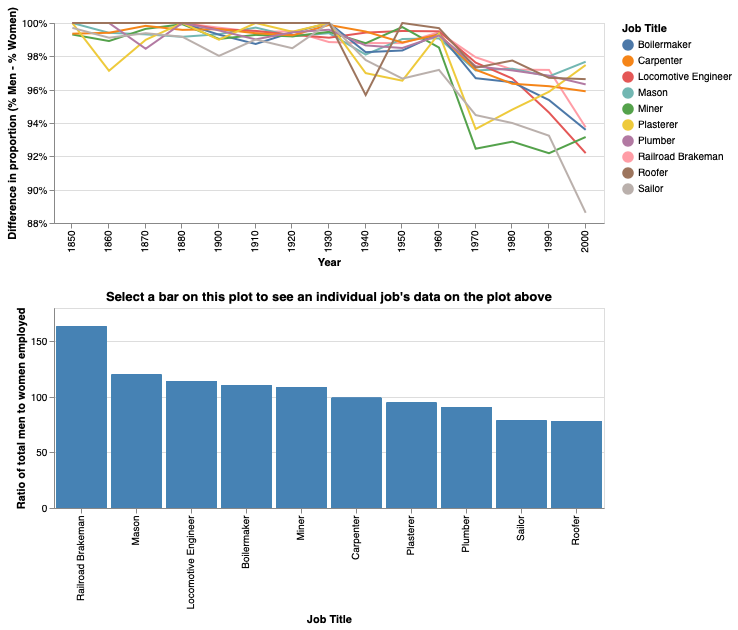

In [10]:
top_10_male_dominated_jobs = ratios_df.sort_values(by = 'ratio', ascending = False).head(10)
source = top_10_male_dominated_jobs.merge(jobs_tidy, how = 'inner', on = 'job')

pts = alt.selection(type="single", encodings=['x'])

lin = alt.Chart(source).mark_line().encode(
    alt.X('year:O', title='Year'),
    alt.Y('gender_prop_diff:Q',
          title="Difference in proportion (% Men - % Women)",
          axis=alt.Axis(format='%'),
          scale=alt.Scale(zero=False)),
    alt.Color('job:N', title= "Job Title")
    
).transform_filter(
    pts
).properties(
    width=550,
    height=200
)

label = alt.selection_single(
    encodings=['x'], # limit selection to x-axis value
    on='mouseover',  # select on mouseover events
    nearest=True,    # select data point nearest the cursor
    empty='none'     # empty selection includes no data points
)

lin_w_interaction = alt.layer(
    lin, # base line chart
        alt.Chart().mark_rule(color='#aaa').encode(
        x='year:O'
    ).transform_filter(label),
    lin.mark_circle().encode(
        opacity=alt.condition(label, alt.value(1), alt.value(0))
    ).add_selection(label),
    lin.mark_text(align='left', dx=5, dy=-5, stroke='white', strokeWidth=2).encode(
        text='gender_prop_diff:Q'
    ).transform_filter(label),
     lin.mark_text(align='left', dx=5, dy=-5).encode(
        text='gender_prop_diff:Q'
    ).transform_filter(label),
    data = source
)

bar = alt.Chart(source).mark_bar().encode(
    x=alt.X('job:N',
            title='Job Title',
            sort=alt.EncodingSortField(field="ratio",op="sum",order="descending" )),
    y=alt.Y('ratio:Q', title="Ratio of total men to women employed"),
    color=alt.condition(pts, alt.ColorValue("steelblue"), alt.ColorValue("grey"))
).properties(
    width=550,
    height=200,
    title="Select a bar on this plot to see an individual job's data on the plot above"
).add_selection(pts)

alt.vconcat(
    lin_w_interaction,
    bar
).resolve_legend(
    color="independent",
    size="independent"
)

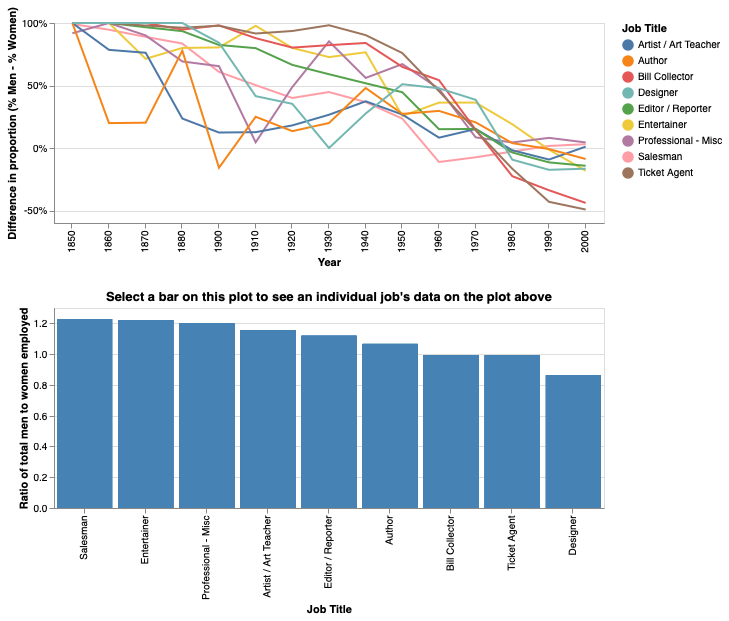

In [11]:
top_9_balanced_jobs = ratios_df.sort_values(by = 'ratio', ascending = False).query("ratio < 5/4 and ratio > 4/5 ")
source = top_9_balanced_jobs.merge(jobs_tidy, how = 'inner', on = 'job')

pts = alt.selection(type="single", encodings=['x'])

lin = alt.Chart(source).mark_line().encode(
    alt.X('year:O', title='Year'),
    alt.Y('gender_prop_diff:Q',
          title="Difference in proportion (% Men - % Women)",
          axis=alt.Axis(format='%'), 
          scale=alt.Scale(zero=False)),
    alt.Color('job:N', title= "Job Title")
    
).transform_filter(
    pts
).properties(
    width=550,
    height=200
)

label = alt.selection_single(
    encodings=['x'], # limit selection to x-axis value
    on='mouseover',  # select on mouseover events
    nearest=True,    # select data point nearest the cursor
    empty='none'     # empty selection includes no data points
)

lin_w_interaction = alt.layer(
    lin, # base line chart
        alt.Chart().mark_rule(color='#aaa').encode(
        x='year:O'
    ).transform_filter(label),
    lin.mark_circle().encode(
        opacity=alt.condition(label, alt.value(1), alt.value(0))
    ).add_selection(label),
    lin.mark_text(align='left', dx=5, dy=-5, stroke='white', strokeWidth=2).encode(
        text='gender_prop_diff:Q'
    ).transform_filter(label),
     lin.mark_text(align='left', dx=5, dy=-5).encode(
        text='gender_prop_diff:Q'
    ).transform_filter(label),
    data = source
)

bar = alt.Chart(source).mark_bar().encode(
    x=alt.X('job:N',
            title='Job Title',
            sort=alt.EncodingSortField(field="ratio",op="sum",order="descending" )),
    y=alt.Y('ratio:Q', title="Ratio of total men to women employed"),
    color=alt.condition(pts, alt.ColorValue("steelblue"), alt.ColorValue("grey"))
).properties(
    width=550,
    height=200,
    title="Select a bar on this plot to see an individual job's data on the plot above"
).add_selection(pts)

alt.vconcat(
    lin_w_interaction,
    bar
).resolve_legend(
    color="independent",
    size="independent"
)

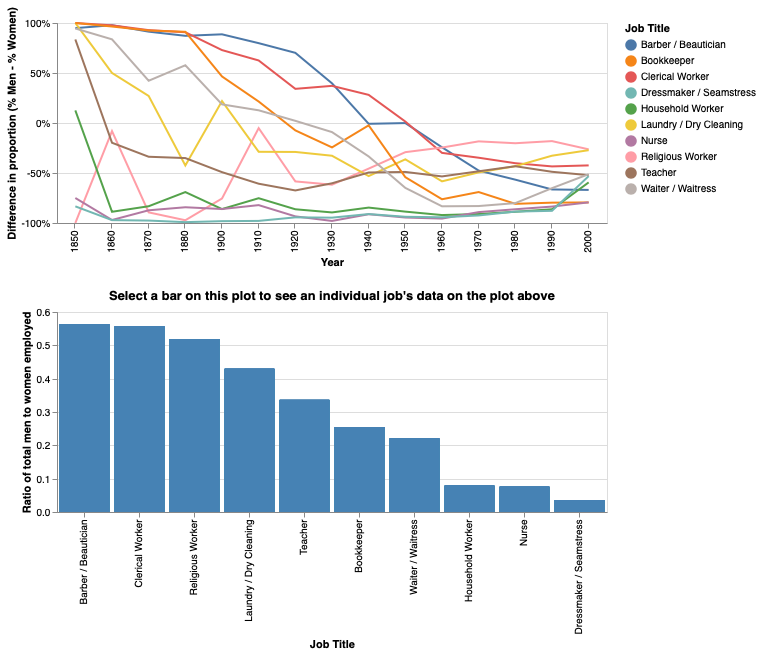

In [12]:
top_10_female_dominated_jobs = ratios_df.sort_values(by = 'ratio', ascending = False).tail(10)
source = top_10_female_dominated_jobs.merge(jobs_tidy, how = 'inner', on = 'job')

pts = alt.selection(type="single", encodings=['x'])

lin = alt.Chart(source).mark_line().encode(
    alt.X('year:O', title='Year'),
    alt.Y('gender_prop_diff:Q',
          title="Difference in proportion (% Men - % Women)",
          axis=alt.Axis(format='%'),
          scale=alt.Scale(zero=False)),
    alt.Color('job:N', title= "Job Title")
    
).transform_filter(
    pts
).properties(
    width=550,
    height=200
)

label = alt.selection_single(
    encodings=['x'], # limit selection to x-axis value
    on='mouseover',  # select on mouseover events
    nearest=True,    # select data point nearest the cursor
    empty='none'     # empty selection includes no data points
)

lin_w_interaction = alt.layer(
    lin, # base line chart
        alt.Chart().mark_rule(color='#aaa').encode(
        x='year:O'
    ).transform_filter(label),
    lin.mark_circle().encode(
        opacity=alt.condition(label, alt.value(1), alt.value(0))
    ).add_selection(label),
    lin.mark_text(align='left', dx=5, dy=-5, stroke='white', strokeWidth=2).encode(
        text='gender_prop_diff:Q'
    ).transform_filter(label),
     lin.mark_text(align='left', dx=5, dy=-5).encode(
        text='gender_prop_diff:Q'
    ).transform_filter(label),
    data = source
)

bar = alt.Chart(source).mark_bar().encode(
    x=alt.X('job:N',
            title='Job Title',
            sort=alt.EncodingSortField(field="ratio",op="sum",order="descending" )),
    y=alt.Y('ratio:Q', title="Ratio of total men to women employed"),
    color=alt.condition(pts, alt.ColorValue("steelblue"), alt.ColorValue("grey"))
).properties(
    width=550,
    height=200,
    title="Select a bar on this plot to see an individual job's data on the plot above"
).add_selection(pts)

alt.vconcat(
    lin_w_interaction,
    bar
).resolve_legend(
    color="independent",
    size="independent"
)